In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import geopandas as gpd
import glob
from tqdm import tqdm

%matplotlib inline
import statsmodels as sm
from statsmodels.imputation import mice
import warnings
warnings.filterwarnings('ignore')

In [2]:
element_list = ['ag', 'al', 'as', 'au', 'b', 'ba', 'be', 'bi', 'ca', 'cd', 'ce', 'co', 'cr', 'cs', 'cu', 'dy', 'er', 'eu', 'fe', 'ga', 'gd', 'ge', 'hf', 'hg', 'ho', 'k', 'la', 'li', 'lu',
                'mg', 'mn', 'mo', 'na', 'nb', 'nd', 'ni', 'os', 'p', 'pb', 'pd', 'pr', 'pt', 'rb', 're', 'rh', 'ru', 'sb', 'sc', 'se', 'sm', 'sn', 'sr', 'ta', 'tb', 'te', 'th', 'ti', 'tl',
                'tm', 'u', 'v', 'w', 'y', 'yb', 'zn', 'zr']

In [3]:
#this cell does all elements at once in a batch
for element in element_list:
    try:
        huc12 = gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
        huc12 = huc12.to_crs({'init': 'epsg:3732'})
        '''
        path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\hotspot analysis\\rock hotspot joined with hucs\\'+element+'\\'
        allFiles=glob.glob(path+"*.xls")
        frame=pd.DataFrame
        listed=[]
        for file in allFiles:
            df = pd.read_excel(file, index_col=[0], sheet=0)
            listed.append(df)
        frame = pd.concat(listed, sort=False)
        '''
        frame = pd.read_excel('J:/Geology/WSGS/Projects/Critical Minerals/hotspot analysis/rock hotspot joined with hucs/'+element+'_SpatialJoin_TableToExcel.xls',index_col=[0], sheet=0)
        frame = frame.drop(columns=['Join_Count', 'TARGET_FID', 'AREA', 'PERIMETER', 'WY_HU12_',
               'WY_HU12_ID', 'HUC_8', 'HUC_10', 'ACRES', 'STATES',
               'NCONTRB_A', 'HU_10_DS', 'HU_10_NAME', 'HU_10_MOD', 'HU_10_TYPE',
               'HU_12_DS', 'HU_12_NAME', 'HU_12_MOD', 'HU_12_TYPE', 'HU_2_NAME',
               'HU_4_NAME', 'HU_6_NAME', 'HU_8_NAME', 'Shape_Leng', 'SOURCE_ID',
               'GiPValue', 'NNeighbors', 'Gi_Bin',
               'Shape_Length', 'Shape_Area'])
        summary = frame.groupby('HUC_12', as_index=False).sum()
        middle=huc12.merge(summary.astype(object), on='HUC_12', how='right')
        combined = huc12.merge(middle[['HUC_12', 'GiZScore']].astype(str), on='HUC_12', how='left')
        combined.dropna(inplace=True)
        plt.figure(figsize=(18,12)) 
        #combined.plot(column=pd.to_numeric(combined['GiZScore']), cmap='magma', legend=True)

        combined['zscore'] = combined.GiZScore.astype(float).values
        combined.to_file(driver='ESRI Shapefile', filename='D:/jupyter/critical minerals/results/'+element+'_rock_heatmap.shp')

        '''
        path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\hotspot analysis\\sed hotspot joined with hucs\\'+element+'\\'
        allFiles=glob.glob(path+"*.csv")
        frame=pd.DataFrame
        listed=[]
        for file in allFiles:
            df = pd.read_csv(file, index_col=[0])
            listed.append(df)
        frame = pd.concat(listed, sort=False)
        '''
        frame = pd.read_csv('J:/Geology/WSGS/Projects/Critical Minerals/hotspot analysis/sed hotspot joined with hucs/'+element+'_ppm.csv')
        summary = frame.groupby('HUC_12', as_index=False).sum()
        middle=huc12.merge(summary.astype(object), on='HUC_12', how='right')
        sed_comb = huc12.merge(middle[['HUC_12', 'z_score']].astype(str), on='HUC_12', how='left')
        crs={'init': 'epsg:3732'}
        sed_comb.dropna(inplace=True)
        sed_comb= sed_comb.to_crs(crs)
        #sed_comb.plot(column=pd.to_numeric(sed_comb['z_score']), cmap='magma', legend=True, figsize=(20,10))
        sed_comb['zscore'] = sed_comb.z_score.astype(float).values

        sed_comb.to_file(driver='ESRI Shapefile', filename='D:/jupyter/critical minerals/results/'+element+'_sed_heatmap.shp')
        #sed_comb[sed_comb['zscore']>=2].to_file(driver='ESRI Shapefile', filename=element+'_potential.shp')
        #sed_comb[sed_comb['zscore']<2].to_file(driver='ESRI Shapefile', filename=element+'_belownbackground.shp')

        missed = sed_comb[(sed_comb['zscore']>=2) & sed_comb['HUC_12'].isin(combined[combined['zscore']<2].HUC_12)]
        missed.drop(['z_score'], axis=1, inplace=True)
        missed['class'] = 'missed'

        known = combined[combined['zscore']>=2]
        known.drop(['GiZScore'], axis=1, inplace=True)
        known['class'] = 'known'

        potential = sed_comb[(sed_comb['zscore']>=2) & (~sed_comb['HUC_12'].isin(missed.HUC_12)) & (~sed_comb['HUC_12'].isin(known.HUC_12))]
        potential.drop(['z_score'], axis=1, inplace=True)
        potential['class'] = 'potential'

        below = sed_comb[(sed_comb['zscore']<=-2) & (sed_comb['HUC_12'].isin(combined[combined['zscore']<=-2].HUC_12))]
        below.drop(['z_score'], axis=1, inplace=True)
        below['class'] = 'below'

        bg = huc12[(~huc12['HUC_12'].isin(below.HUC_12)) & (~huc12['HUC_12'].isin(potential.HUC_12)) & (~huc12['HUC_12'].isin(known.HUC_12)) & (~huc12['HUC_12'].isin(missed.HUC_12))]
        bg['class'] = 'background'

        classes = pd.concat([missed, known, potential, bg, below], sort=True)
        classes.to_file(driver='ESRI Shapefile', filename='D:/jupyter/critical minerals/results/'+element+'_classes.shp')
    except:
        print(element+' was not successfully written to shapefile')



er was not successfully written to shapefile
ga was not successfully written to shapefile
gd was not successfully written to shapefile
ge was not successfully written to shapefile
hg was not successfully written to shapefile
ho was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


nd was not successfully written to shapefile
os was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


pd was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


pr was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


pt was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


re was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


rh was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


ru was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creat

te was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


tl was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


tm was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


u was not successfully written to shapefile


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creat

zr was not successfully written to shapefile


<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


<Figure size 1296x864 with 0 Axes>

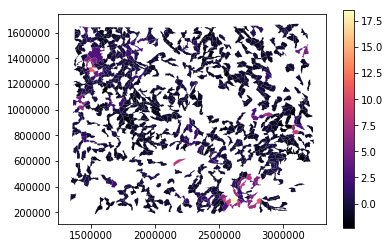

In [70]:
element = 'au'
#this cell creates individual rock heatmaps
huc12 = gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12 = huc12.to_crs({'init': 'epsg:3732'})
'''
#this section will build the maps for REE's and other maps where we combine elements like AuCuZn
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\hotspot analysis\\rock hotspot joined with hucs\\'+element+'\\'
allFiles=glob.glob(path+"*.xls")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_excel(file, index_col=[0], sheet=0)
    listed.append(df)
frame = pd.concat(listed, sort=False)
'''
frame = pd.read_excel('J:/Geology/WSGS/Projects/Critical Minerals/hotspot analysis/rock hotspot joined with hucs/'+element+'_SpatialJoin_TableToExcel.xls',index_col=[0], sheet=0)
frame = frame.drop(columns=['Join_Count', 'TARGET_FID', 'AREA', 'PERIMETER', 'WY_HU12_',
       'WY_HU12_ID', 'HUC_8', 'HUC_10', 'ACRES', 'STATES',
       'NCONTRB_A', 'HU_10_DS', 'HU_10_NAME', 'HU_10_MOD', 'HU_10_TYPE',
       'HU_12_DS', 'HU_12_NAME', 'HU_12_MOD', 'HU_12_TYPE', 'HU_2_NAME',
       'HU_4_NAME', 'HU_6_NAME', 'HU_8_NAME', 'Shape_Leng', 'SOURCE_ID',
       'GiPValue', 'NNeighbors', 'Gi_Bin',
       'Shape_Length', 'Shape_Area'])
summary = frame.groupby('HUC_12', as_index=False).sum()
middle=huc12.merge(summary.astype(object), on='HUC_12', how='right')
combined = huc12.merge(middle[['HUC_12', 'GiZScore']].astype(str), on='HUC_12', how='left')
combined.dropna(inplace=True)
plt.figure(figsize=(18,12)) 
#combined.plot(column=pd.to_numeric(combined['GiZScore']), cmap='magma', legend=True)

combined['zscore'] = combined.GiZScore.astype(float).values
combined.to_file(driver='ESRI Shapefile', filename='D:/jupyter/critical minerals/results/'+element+'_rock_heatmap.shp')

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


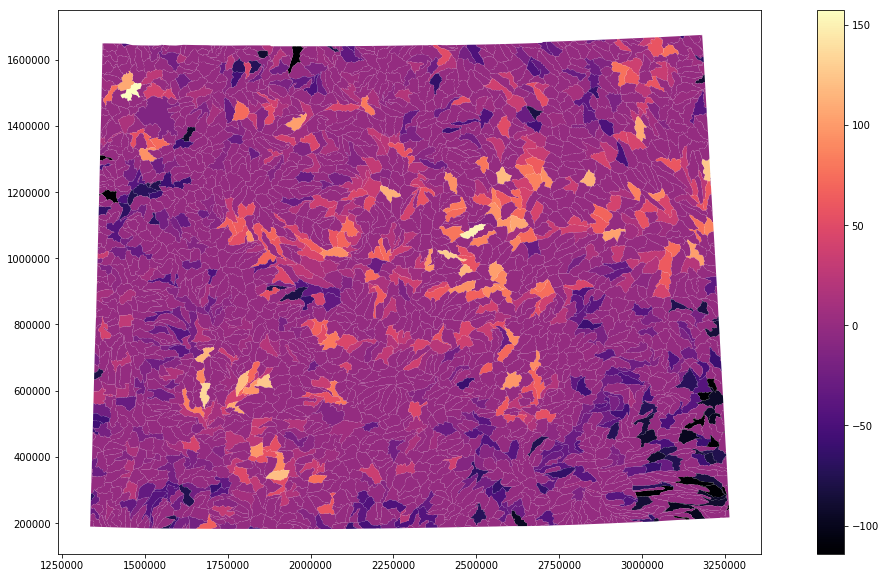

In [71]:
'''
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\hotspot analysis\\sed hotspot joined with hucs\\'+element+'\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed, sort=False)
'''
frame = pd.read_csv('J:/Geology/WSGS/Projects/Critical Minerals/hotspot analysis/sed hotspot joined with hucs/'+element+'_ppm.csv')
summary = frame.groupby('HUC_12', as_index=False).sum()
middle=huc12.merge(summary.astype(object), on='HUC_12', how='right')
sed_comb = huc12.merge(middle[['HUC_12', 'z_score']].astype(str), on='HUC_12', how='left')
crs={'init': 'epsg:3732'}
sed_comb.dropna(inplace=True)
sed_comb= sed_comb.to_crs(crs)
sed_comb.plot(column=pd.to_numeric(sed_comb['z_score']), cmap='magma', legend=True, figsize=(20,10))
sed_comb['zscore'] = sed_comb.z_score.astype(float).values

sed_comb.to_file(driver='ESRI Shapefile', filename='D:/jupyter/critical minerals/results/'+element+'_sed_heatmap.shp')
#sed_comb[sed_comb['zscore']>=2].to_file(driver='ESRI Shapefile', filename=element+'_potential.shp')
#sed_comb[sed_comb['zscore']<2].to_file(driver='ESRI Shapefile', filename=element+'_belownbackground.shp')

In [72]:
missed = sed_comb[(sed_comb['zscore']>=2) & sed_comb['HUC_12'].isin(combined[combined['zscore']<2].HUC_12)]
missed.drop(['z_score'], axis=1, inplace=True)
missed['class'] = 'missed'

known = combined[combined['zscore']>=2]
known.drop(['GiZScore'], axis=1, inplace=True)
known['class'] = 'known'

potential = sed_comb[(sed_comb['zscore']>=2) & (~sed_comb['HUC_12'].isin(missed.HUC_12)) & (~sed_comb['HUC_12'].isin(known.HUC_12))]
potential.drop(['z_score'], axis=1, inplace=True)
potential['class'] = 'potential'

below = sed_comb[(sed_comb['zscore']<=-2) & (sed_comb['HUC_12'].isin(combined[combined['zscore']<=-2].HUC_12))]
below.drop(['z_score'], axis=1, inplace=True)
below['class'] = 'below'

bg = huc12[(~huc12['HUC_12'].isin(below.HUC_12)) & (~huc12['HUC_12'].isin(potential.HUC_12)) & (~huc12['HUC_12'].isin(known.HUC_12)) & (~huc12['HUC_12'].isin(missed.HUC_12))]
bg['class'] = 'background'


C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


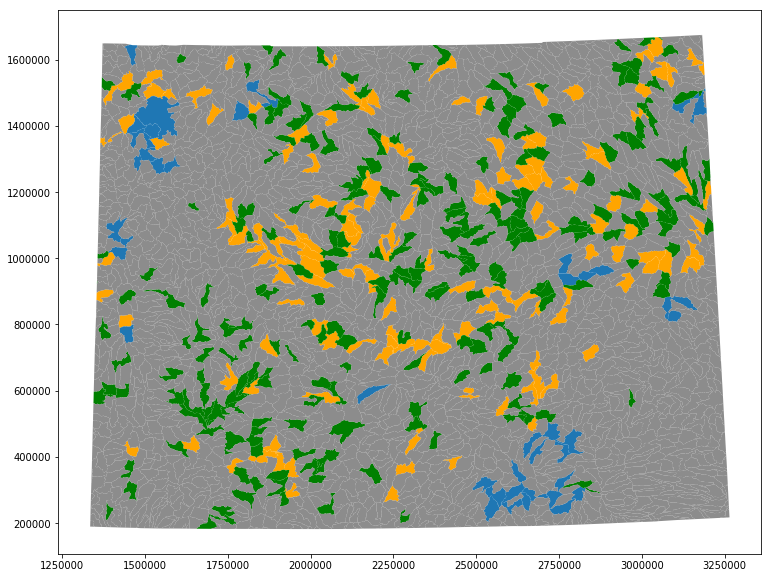

In [73]:
ax = missed.plot(color='orange', figsize=(20,10))
known.plot(ax=ax)
potential.plot(ax=ax, color='green')
below.plot(ax=ax, color='k', alpha = 0.9)
bg.plot(ax=ax, color='gray', alpha =0.9)

In [75]:
classes = pd.concat([missed, known, potential, bg, below], sort=True)
classes.to_file(driver='ESRI Shapefile', filename='D:/jupyter/critical minerals/results/'+element+'_classes.shp')


C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
